In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

from stateless_optim import *

In [3]:
#export
def compose_inplace(item, fns, **hyper_params):
    for fn in fns:
        fn(item, **hyper_params)

In [4]:
#export
def momentum_step(param, learning_rate, avg_grad, **kwargs):
    param.data -= learning_rate * avg_grad

In [5]:
#export
class StatefulOpt():
    def __init__(self, params, steppers=None, stats=None, **hyper_params):
        self.params = [params] if isinstance(params, list) else [[params]]
        self.steppers = steppers if steppers != None else [sgd_step]
        self.stats = stats if stats != None else []
        self.state = {}
        self.hypers = [dict(hyper_params) for p in self.params]

    def _grad_params(self):
        return [(p, h) for ps, h in zip(self.params, self.hypers) for p in ps if p.grad != None]
    
    def step(self):
        for p, hps in self._grad_params():
            if p not in self.state:
                self.state[p] = {}
                for stat in self.stats:
                    self.state[p].update(stat.init_state(p).items())
            # update individual stat states
            p_state = self.state[p]
            for stat in self.stats:
                p_state = stat.update_state(p, p_state, **hps)
            # step
            compose_inplace(p, self.steppers, **p_state, **hps)
            self.state[p] = p_state

    def zero_grad(self):
        for hps in self.params: 
            for hp in hps:
                hp.zero_grad()

    def __repr__(self):
        return f'(StatefulOpt) steppers: {[stepper.__name__ for stepper in self.steppers]}, stats: {[stat.__class__.__name__ for stat in self.stats]}'

In [6]:
#export
class Stat():    
    def init_state(self, param): 
        raise NotImplementedError('Stat.init_state')
        
    def update_state(self, param, state, **kwargs): 
        raise NotImplementedError('Stat.update')

class WeightedSumGrad(Stat):    
    def init_state(self, param):
        return {'avg_grad': torch.zeros_like(param.grad.data)}
    
    def update_state(self, param, state, mom, **kwargs):
        state['avg_grad'] = weighted_sum(state['avg_grad'], param.grad, mom)
        return state

In [7]:
#export
class StepCount(Stat):
    def init_state(self,p): 
        return {'step': 0}
    
    def update_state(self, p, state, **kwargs):
        state['step'] += 1
        return state

class ExpWeightedGrad(Stat):
    # exponentially weighted moving avg of gradient
    def __init__(self, dampening=False): 
        self.dampening = dampening
    
    def init_state(self, param): 
        return {'avg_grad': torch.zeros_like(param.grad.data)}
    
    def update_state(self, param, state, mom, **kwargs):
        state['damp_mom'] = 1. - mom if self.dampening else 1. 
        state['avg_grad'].mul_(mom).add_(state['damp_mom'], param.grad.data)
        return state

class ExpWeightedSqrGrad(Stat):
    def __init__(self, dampening=True):
        self.dampening = dampening
    
    def init_state(self, param): 
        return {'sqr_avg_grad': torch.zeros_like(param.grad.data)}
    
    def update_state(self, param, state, sqr_mom, **kwargs):
        state['sqr_damp_mom'] = 1. - sqr_mom if self.dampening else 1. 
        state['sqr_avg_grad'].mul_(sqr_mom).addcmul_(state['sqr_damp_mom'], param.grad.data, param.grad.data)
        return state

In [8]:
#export
def debias(mom, damp, step): 
    return damp * (1. - mom**step) / (1. - mom)

def adam(param, learning_rate, mom, damp_mom, step, sqr_mom, sqr_damp_mom, avg_grad, sqr_avg_grad, eps=1e-5, **kwargs):
    debias1 = debias(mom,     damp_mom,     step)
    debias2 = debias(sqr_mom, sqr_damp_mom, step)
    param.data.addcdiv_(-learning_rate/debias1, avg_grad, (sqr_avg_grad/debias2).sqrt() + eps)    
    return param

def adam_opt(model, beta1=0.9, beta2=0.99, **kwargs):
    return StatefulOpt(list(model.parameters()), [adam, l2_reg], 
                       [ExpWeightedGrad(True), ExpWeightedSqrGrad(), StepCount()],
                       mom=beta1, sqr_mom=beta2, **kwargs)

In [9]:
#export
def lamb_step(param, learning_rate, mom, damp_mom, step, sqr_mom, sqr_damp_mom, avg_grad, sqr_avg_grad, weight_decay, eps=1e-5, **kwargs):
    debias1 = debias(mom,     damp_mom,     step)
    debias2 = debias(sqr_mom, sqr_damp_mom, step)
    r1 = param.data.pow(2).mean().sqrt()
    step = (avg_grad/debias1) / ((sqr_avg_grad/debias2).sqrt() + eps) + weight_decay*param.data
    r2 = step.pow(2).mean().sqrt()
    param.data.add_(-learning_rate * min(r1/r2, 10), step)
    return param

def lamb_opt(model, beta1=0.9, beta2=0.99, **kwargs):
    return StatefulOpt(list(model.parameters()), [lamb_step], 
                       [ExpWeightedGrad(True), ExpWeightedSqrGrad(), StepCount()],
                       mom=beta1, sqr_mom=beta2, **kwargs)

## Try Momentum + Weight Decay

In [10]:
hyper_params = {'weight_decay':1e-4, 'learning_rate':0.001, 'mom':0.9}
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.01, 0.5, 0.01))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
optimizer = StatefulOpt(list(model.parameters()), steppers=[l2_reg, sgd], stats=[WeightedSumGrad()], **hyper_params)
loss_fn = CrossEntropy()
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(StatefulOpt) steppers: ['l2_reg', 'sgd'], stats: ['WeightedSumGrad']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging']


In [11]:
learner.fit(5)

Epoch - 1
train metrics - [0.00028108856201171877, 0.88826]
valid metrics - [1.8227243423461913e-05, 0.9633]

Epoch - 2
train metrics - [4.000959396362305e-06, 0.95636]
valid metrics - [1.00006103515625e-05, 0.9684]

Epoch - 3
train metrics - [0.00015014328956604003, 0.966]
valid metrics - [1.3134193420410156e-05, 0.9722]

Epoch - 4
train metrics - [2.1616554260253905e-06, 0.97036]
valid metrics - [3.2955169677734375e-06, 0.9731]

Epoch - 5
train metrics - [2.049203872680664e-05, 0.97344]
valid metrics - [2.381134033203125e-06, 0.9749]



## Try Adam + Weight Decay

In [12]:
hyper_params = {'learning_rate':0.001, 'weight_decay':1e-4}
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.0001, 0.003, 0.0001))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
loss_fn = CrossEntropy()
optimizer = adam_opt(model, **hyper_params)
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging(), Recorder()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(StatefulOpt) steppers: ['adam', 'l2_reg'], stats: ['ExpWeightedGrad', 'ExpWeightedSqrGrad', 'StepCount']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging', 'Recorder']


In [13]:
learner.fit(5)

Epoch - 1
train metrics - [1.8053569793701172e-05, 0.85898]
valid metrics - [3.791632652282715e-05, 0.959]

Epoch - 2
train metrics - [2.90731143951416e-05, 0.95446]
valid metrics - [2.0032882690429688e-05, 0.9703]

Epoch - 3
train metrics - [6.13229751586914e-05, 0.9634]
valid metrics - [1.1788225173950195e-05, 0.9698]

Epoch - 4
train metrics - [5.3541851043701175e-06, 0.96956]
valid metrics - [4.039287567138672e-06, 0.9722]

Epoch - 5
train metrics - [1.6351699829101563e-07, 0.97354]
valid metrics - [2.5911331176757813e-06, 0.9719]



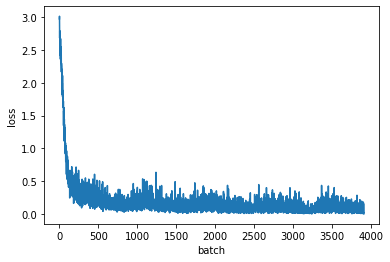

In [14]:
learner.callbacks[3].plot_losses()

## Try LAMB

In [15]:
hyper_params = {'weight_decay':1e-4, 'learning_rate':0.001}
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.0001, 0.003, 0.0001))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
loss_fn = CrossEntropy()
optimizer = lamb_opt(model, **hyper_params)
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging(), Recorder()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(StatefulOpt) steppers: ['lamb_step'], stats: ['ExpWeightedGrad', 'ExpWeightedSqrGrad', 'StepCount']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging', 'Recorder']


In [16]:
learner.fit(5)

Epoch - 1
train metrics - [3.1355996131896974e-05, 0.77714]
valid metrics - [0.00012791762351989746, 0.947]

Epoch - 2
train metrics - [1.0095691680908203e-05, 0.94534]
valid metrics - [5.886983871459961e-05, 0.9621]

Epoch - 3
train metrics - [2.003335952758789e-05, 0.95894]
valid metrics - [4.677410125732422e-05, 0.9654]

Epoch - 4
train metrics - [9.08242130279541e-05, 0.96594]
valid metrics - [3.3396291732788084e-05, 0.9691]

Epoch - 5
train metrics - [4.072021961212158e-05, 0.97088]
valid metrics - [1.6801071166992188e-05, 0.9692]



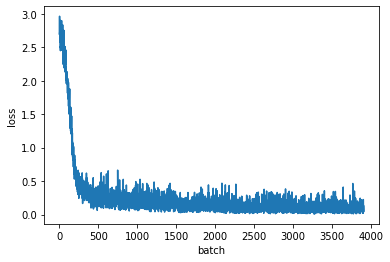

In [17]:
learner.callbacks[3].plot_losses()